### *References*

*1. https://photutils.readthedocs.io/en/stable/background.html*

*2. https://www.kaggle.com/akhileshdkapse/foreground-extraction-opencv*

*3. https://github.com/akTwelve/tutorials/blob/master/image_composition/BasicImageComposition.ipynb*

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2

In [2]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from image_preprocessing import datagens, prepareImages, prepareLabels
from train_valid_split import train_valid_split, train_valid_dict_generator

In [5]:
from model import model_deep
from vgg16 import VGG_16

In [6]:
from tensorflow.keras.optimizers import Adam

In [7]:
import matplotlib.pyplot as plt

In [8]:
import matplotlib.image as mpimg

In [9]:
from sklearn.cluster import KMeans

In [10]:
from tqdm import tqdm
import os

In [11]:
import json

In [12]:
from sklearn.cluster import KMeans

In [85]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

## Review the Imbalance in the Dataset

In [13]:
# load original data with image names and Ids
train_labels = pd.read_csv("train.csv")

In [14]:
count_categories = train_labels['Id'].value_counts(ascending=False).to_frame()
underrepresented = count_categories[count_categories['Id']<=30]

In [15]:
underrep_categories = list(underrepresented.index.values)

In [16]:
overrepresented = count_categories[count_categories['Id']>=1000]

In [17]:
overrep_categories = list(overrepresented.index.values)

In [18]:
# print(underrep_categories)
print(overrep_categories)

['new_whale']


In [19]:
count_categories.head(3)

Id
new_whale  9664
w_23a388d    73
w_9b5109b    65

In [20]:
count_categories.tail(5)

Id
w_bad166a   1
w_1b50676   1
w_fa3a41f   1
w_bca4304   1
w_c190aa8   1

- The "new_whale" category is the most represented category in our dataset which complicates matters.
- There are a lot of underrepresented (less than or equal to 30 sightings) classes of whales, which also contributes to imbalance. Could we use synthetic data generation to solve this issue?


## Review "new_whale" Images

In [21]:
train_new_whales = train_labels[train_labels['Id'] == 'new_whale']

In [22]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    
    plt.figure(figsize=(5,6))
    plt.imshow(image)    

In [23]:
path = '...\\Documents\\whale_identification\\whale_identification\\data\\train\\'

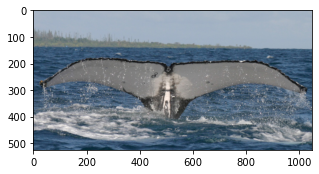

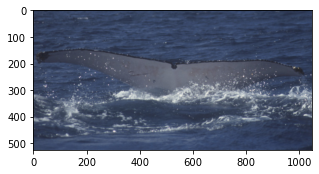

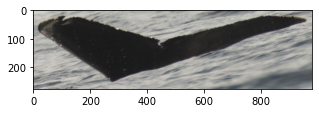

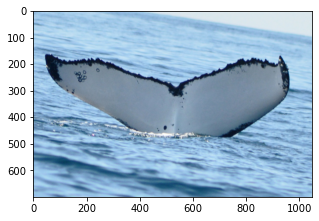

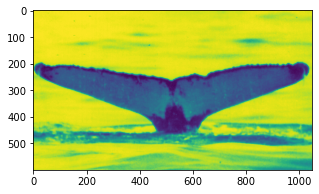

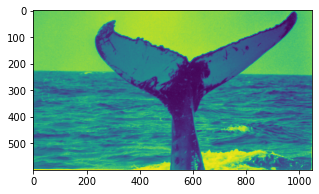

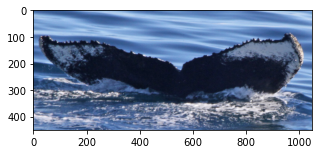

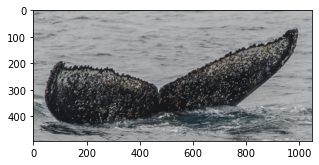

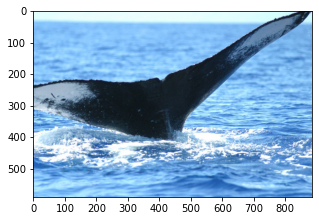

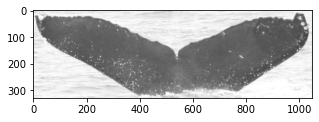

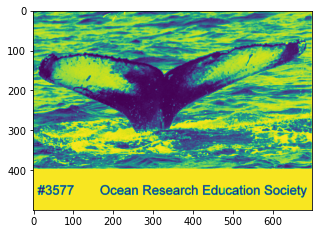

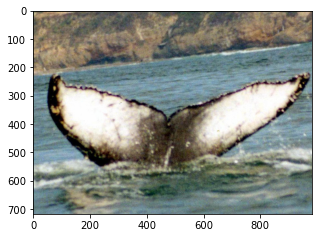

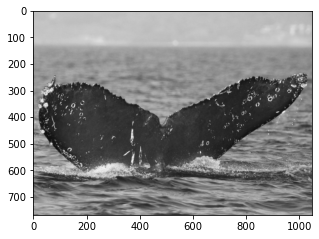

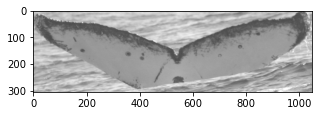

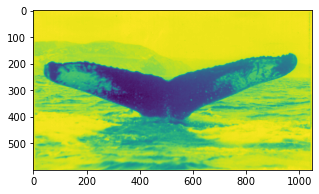

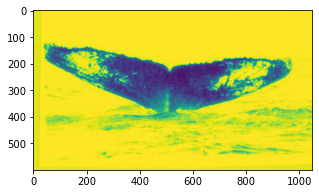

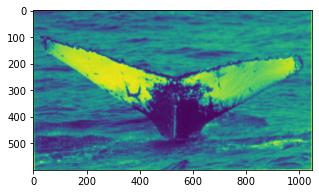

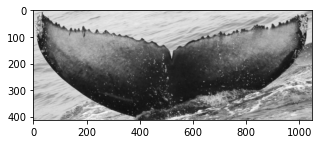

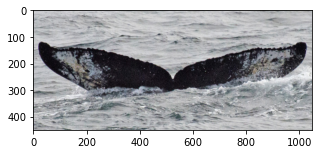

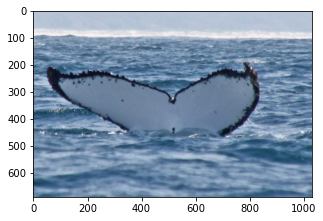

In [24]:
for i in range(0,20):
    
    process( path + train_new_whales.iloc[i,0])

- Looks like "new whales" are, in fact, different categories for which no current labels apply to + images differ in format, as well.
- Could we potentially group them into arbitrarily-named categories based on image similarity? It looks like some of the images belong to the same whale type.

## Review Images Belonging to the Same Class

In [25]:
first_class = train_labels[train_labels['Id'] == train_labels.loc[0,'Id']]

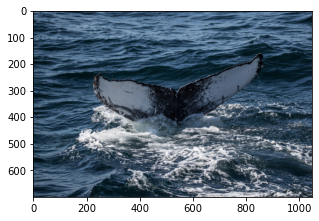

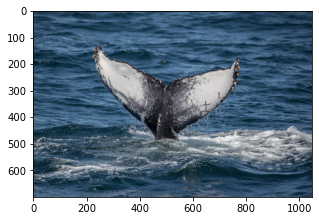

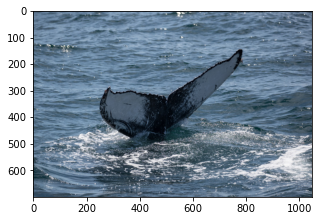

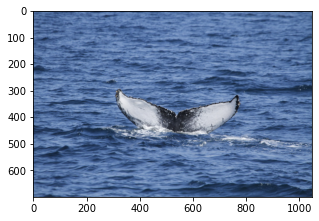

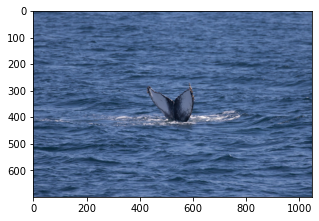

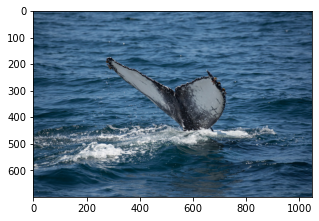

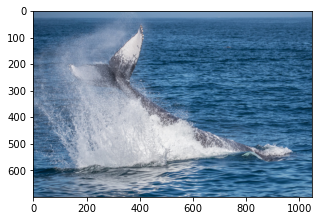

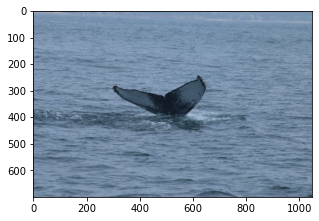

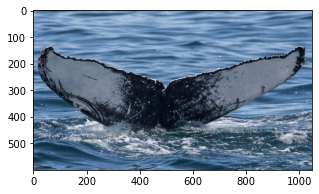

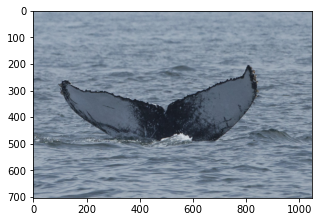

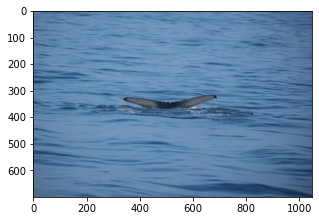

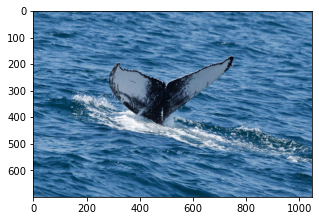

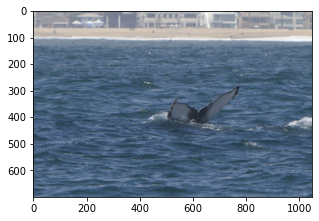

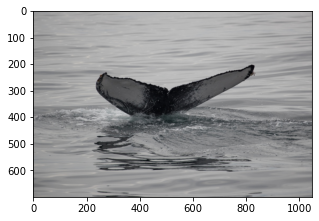

In [26]:
for i in range(0,len(first_class)):
    
    process( path + first_class.iloc[i,0])

- Images vary in zoom, flip, rotation, background effects (waves), so the algorithm should learn to recognize the pattern on the tail well through all these differences.

## Approach

- To create more balance: 
            - regroup new whale categories based on similarity, if it's meaningful,
            - downsize the new whale class, if needed,
            - create synthetic data for underrepresented categories.            

### *1. Regrouping New Whales into Separate Categories Based on Similarity (using k-NN)*


In [25]:
model = model_deep(weights_path = r'...\Documents\whale_identification\whale_identification\_weights_.h5')

In [26]:
X_new_whales = prepareImages(train_new_whales,train_new_whales.shape[0], path)

Processing image:  1 ,  00050a15a.jpg
Processing image:  501 ,  0c2653d9e.jpg
Processing image:  1001 ,  1a33bd79a.jpg
Processing image:  1501 ,  27532de9c.jpg
Processing image:  2001 ,  34c27f593.jpg
Processing image:  2501 ,  4183a0bf4.jpg
Processing image:  3001 ,  4e3f49baf.jpg
Processing image:  3501 ,  5b3e7b0e3.jpg
Processing image:  4001 ,  69238a018.jpg
Processing image:  4501 ,  76a42b54e.jpg
Processing image:  5001 ,  8310d8384.jpg
Processing image:  5501 ,  9061f131f.jpg
Processing image:  6001 ,  9d48d4d48.jpg
Processing image:  6501 ,  aa073f455.jpg
Processing image:  7001 ,  b70f045d6.jpg
Processing image:  7501 ,  c5b64baa1.jpg
Processing image:  8001 ,  d36bfbf0e.jpg
Processing image:  8501 ,  dfb446097.jpg
Processing image:  9001 ,  edaf2b4a5.jpg
Processing image:  9501 ,  fb4c50bd5.jpg


In [27]:
# apply data augmentations
train_datagen, valid_datagen = datagens()

In [28]:
new_whale_ftrs = model.predict(X_new_whales)

In [29]:
len(new_whale_ftrs)

9664

In [31]:
kmeans = KMeans(random_state=0).fit(new_whale_ftrs)
print(kmeans.labels_)

[0 3 4 ... 3 4 7]


In [32]:
len(kmeans.labels_)

9664

In [33]:
train_new_whales['cluster'] = kmeans.labels_

C:\Users\janizd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
train_new_whales['cluster'].unique()

array([0, 3, 4, 5, 2, 1, 6, 7])

In [35]:
cluster_0 = train_new_whales[train_new_whales['cluster'] == 0]

In [36]:
cluster_6 = train_new_whales[train_new_whales['cluster'] == 6]

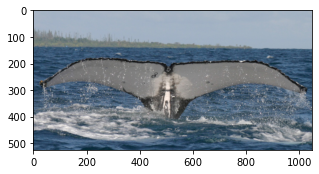

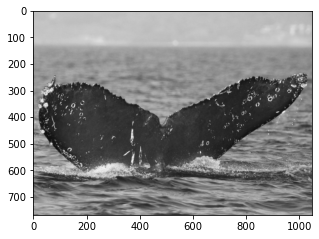

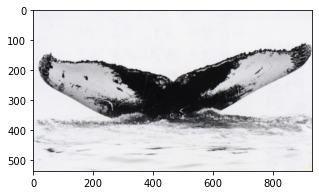

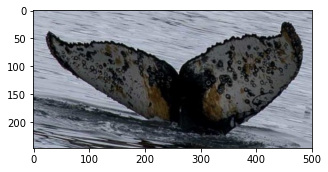

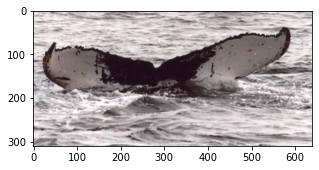

In [37]:
for i in range(0,5):
    process(path + cluster_0.iloc[i,0])

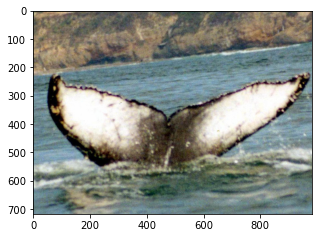

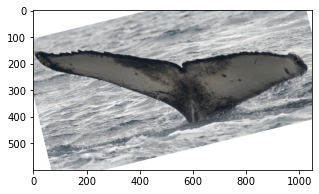

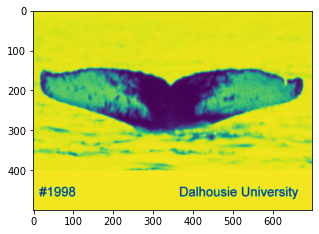

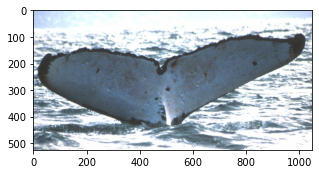

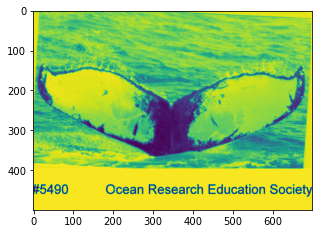

In [38]:
for i in range(0,5):
    process(path + cluster_6.iloc[i,0])

- Looks like the images in distinct clusters are too dissimilar for them to be grouped together.
- Let's drop the "new_whale" category altogether to facilitate better prediction accuracy of our CNN.

In [27]:
train_labels.drop(train_labels[train_labels['Id'] =='new_whale'].index, inplace=True)

In [28]:
len(train_labels)

15697

### *2. Create Synthetic Data for Underrepresented Categories*

In [29]:
count_categories_2 = train_labels['Id'].value_counts(ascending=False).to_frame()
len(count_categories_2['Id']<30)

5004

In [30]:
ids = count_categories_2[count_categories_2['Id']<30]

In [31]:
# dataframe of whale categories with less than 30 images per category
underrep = train_labels[train_labels['Id'].isin(ids.index.values)]

###### *foreground extraction (ref. #2)*

In [63]:
# load image and set to rgb
def load(path, size=128):
    img= cv2.resize(cv2.imread(path),(size,size))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [51]:
# compressed image re-creation
def k_means(img, n_colors= 4):
    
    w, h, d = original_shape = tuple(img.shape)
    img= img/255.0
    image_array = np.reshape(img, (w * h, d))
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)
    labels = kmeans.predict(image_array)
    
    codebook= kmeans.cluster_centers_ # recreate the compressed image from codebook and labels
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [66]:
# extract foreground using grabCut
def forgrd_ext(img, rec):
    mask= np.zeros(img.shape[:2], np.uint8)
    bgmodel= np.zeros((1, 65), np.float64)
    fgmodel= np.zeros((1, 65), np.float64)
    cv2.grabCut(img, mask, rec, bgmodel, fgmodel, 3, cv2.GC_INIT_WITH_RECT)
    mask2= np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    img= img*mask2[:,:,np.newaxis]
    img[np.where((img == [0,0,0]).all(axis = 2))] = [255.0, 255.0, 255.0]
    return img

In [52]:
# find the bounding box containing the whale's tail
def find_box(edges):
    
    #contour masking
    co, hi = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    con=max(co,key=cv2.contourArea)
    conv_hull=cv2.convexHull(con)
    
    top=tuple(conv_hull[conv_hull[:,:,1].argmin()][0])
    bottom=tuple(conv_hull[conv_hull[:,:,1].argmax()][0])
    left=tuple(conv_hull[conv_hull[:,:,0].argmin()][0])
    right=tuple(conv_hull[conv_hull[:,:,0].argmax()][0])
    
    return top, bottom, left, right

In [78]:
# extract the foreground containing the whale's tail and write it to a separate folder
for i in range(0, len(underrep)):
        
    path= os.path.join('...\\Documents\\whale_identification\\whale_identification\\data\\train\\', underrep.iloc[i,0])
    img_id= underrep.iloc[i,1]

    img=load(path, 128)
    org=img.copy()
    img= k_means(img , n_colors= 10) # recreate image in a compressed form

    img_gray= cv2.cvtColor(np.uint8(img*255), cv2.COLOR_RGB2GRAY) # convert image to gray
    img_gray= cv2.medianBlur(img_gray,7) # blur the image
    edges = cv2.Canny(img_gray,100,200) # detect the edges in the image

    kernel= cv2.getStructuringElement(cv2.MORPH_RECT,(15,15)) # get the desired kernel
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel) #  close small holes inside the foreground object

    top,bottom,left,right = find_box(edges) # draw bounding box containing the tail
    rec= (left[0], top[1], right[0]-left[0], bottom[1]-top[1])
    forground_img= forgrd_ext(org, rec) # extract the foreground
    pt = '...\\Documents\\whale_identification\\whale_identification\\data\\fgs\\'
    cv2.imwrite(pt + str(img_id)+'fg'+str(i)+'.jpg', forground_img) # save in a separate folder

ValueError: max() arg is an empty sequence

- ignore the error above (the operation more-or-less successfully terminated, as evidenced by the number of images in the "fgs" folder.)

In [89]:
fgs = os.listdir('...\\Documents\\whale_identification\\whale_identification\\data\\fgs\\')
len(fgs)

4226

##### *background extraction (ref. #1)*

In [87]:
for i in range(0, len(underrep)):
    
    path= os.path.join('...\\Documents\\whale_identification\\whale_identification\\data\\train\\', underrep.iloc[i,0])
    img_id= underrep.iloc[i,1]
    im = cv2.imread(path)
    img_gray= cv2.cvtColor(np.uint8(im*255), cv2.COLOR_RGB2GRAY) # convert to gray (2D)
    sigma_clip = SigmaClip(sigma=3.) # sigma-clipped 
    bkg_estimator = MedianBackground() # median using an instance of MedianBackground
    bkg = Background2D(img_gray, (60,60), filter_size=(3, 3), 
                sigma_clip=sigma_clip, bkg_estimator=bkg_estimator) # background level as the sigma-clipped median 
    pt = '...\\Documents\\whale_identification\\whale_identification\\data\\bgs\\' # path to save the images
    cv2.imwrite(pt + str(img_id)+'bg'+str(i)+'.jpg', bkg.background) # save in a separate folder

ValueError: All meshes contain > 180.0 (10.0 percent per mesh) masked pixels.  Please check your data or decrease "exclude_percentile".

- ignore the error above (the operation successfully terminated, with enough background images for synthetic data generation).

In [90]:
bgs = os.listdir('...\\Documents\\whale_identification\\whale_identification\\data\\bgs\\')
len(bgs)

3827

#### *output synthetic images for underrepresented categories (ref. #3)*

In [217]:
new_size = (160,160)

In [236]:
for i in range(0, len(fgs)):
    
    foreground = Image.open('...\\Documents\\whale_identification\\whale_identification\\data\\fgs\\'+fgs[i])
    foreground_alpha = np.array(foreground.getchannel(2))
    
    # create about 40 synthetic images for each foreground
    for j in range(0,40):
        background = Image.open('...\\Documents\\whale_identification\\whale_identification\\data\\bgs\\'+bgs[j])
        background = background.convert('RGB')
        
        foreground = foreground.resize(new_size, resample = Image.BICUBIC) # rescale the image
        background = background.resize(new_size) # rescale the image
        
        new_foreground = Image.new('RGB', background.size, color = (0,0,0,0)) # create a new fg as large as a bg
        max_xy_position = (background.size[0] - foreground.size[0], 
                           background.size[1] - foreground.size[1]) # choose a random x, y position for fg
        
        paste_position = (random.randint(0, max_xy_position[0]), random.randint(0, max_xy_position[1]))
        
        new_foreground.paste(foreground,paste_position) # paste on top
        alpha_mask = foreground.getchannel(2) # extract alpha channel and paste it onto a new image
        new_alpha_mask = Image.new('L', background.size, color = 0)
        new_alpha_mask.paste(alpha_mask, paste_position)
        
        composite = Image.composite(background,new_foreground, new_alpha_mask) # compose the image
        
        composite.save('...\\Documents\\whale_identification\\whale_identification\\data\\train\\'+fgs[i][:-4] + str(j) + '.jpg') 
    

#### *create a final modified dataframe incorporating synthetic images*

In [254]:
train_imgs = os.listdir('...\\Documents\\whale_identification\\whale_identification\\data\\train\\')

In [256]:
train_imgs_dict = {}

In [263]:
for i in range(0, len(train_imgs)):
      
    if train_imgs[i] in list(train_labels['Image']):
        train_imgs_dict[train_imgs[i]] = train_labels[train_labels['Image'] == train_imgs[i]].iloc[0,1]
    else:
        train_imgs_dict[train_imgs[i]] = train_imgs[i][:9]

In [265]:
df_train = pd.DataFrame(list(train_imgs_dict.items()),columns = ['Image','Id']) 

In [266]:
df_train.head()

Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  00050a15a
4  0005c1ef8.jpg  0005c1ef8

In [267]:
df_train.to_csv("df_train.csv")